In [1]:
import sys
import pandas as pd
import utils
import numpy as np
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection 
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
import statsmodels.formula.api as sm
from sklearn.metrics import roc_auc_score
from collections import Counter
from timeit import default_timer as timer
import pickle

In [2]:
args = sys.argv
#'AGP_max_k5&
cohort_list ='Thomas_k7'#'CRC_thomas_otu' #'' 'Thomas_k6'#'Thomas_k6'#'CRC_k6'#'Thomas_k6&Thomas_k7' #Thomas_k7'#'''AGP_max_k5&AGP_max_k6'#'AGP_max_k7'#'T2D_k6&T2D_k7'#'Thomas_k6&Thomas_k7' #"CRC_k6&CRC_k7"#'Hispanic_k5&Hispanic_k6&Hispanic_k7'#Thomas_k6'#'Hispanic_k5&Hispanic_k6&Hispanic_k7'#'T2D_k6&T2D_k7'#"CRC_k6&CRC_k7"#'T2D_k6&T2D_k7' # 
phenotype = 'bin_crc_normal'#"bin_antibiotic_last_year"#"'bmi_corrected'#"bin_t2d"#''antibiotic'#'bmi_corrected'# 'bin_crc_adenomaORnormal'#""bin_antibiotic_last_year"#'bin_crc_normal'#
pred_bool = 0
val_bool = 1
args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list, 'kmer', 'BatchCorrected', phenotype, 1, 0,
        10, 'dataaug',"dataaug_grid_trans_none",0,pred_bool]
# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list, 'kmer', 'BatchCorrected', phenotype, 1, 0,
#         10, 'domaincorr',"domaincorr_grid_trans_none",0,pred_bool]
# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list, 'kmer', 'BatchCorrected', phenotype, 1, 0,
#         10, 'raw',"raw_grid_trans_none",0,pred_bool]
# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list , 'kmer', 'BatchCorrected', phenotype, 1, 0,
#         10, 'minervaclrscale',"MINERVA_grid_trans_clr_scale",1,pred_bool]
# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list , 'kmer', 'BatchCorrected', phenotype, 1, 0,
#         10, 'minervaclrscaleLODO',"MINERVALODO_grid_trans_clr_scale",1,pred_bool]
# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list , 'kmer', 'BatchCorrected', phenotype, 1, 0,
#         10, 'pc_lodo',"pc_lodo_grid_trans_clr_scale",1,pred_bool]
# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list, 'kmer', 'BatchCorrected', phenotype, 1, 0,
#         10, 'raw',"raw_grid_trans_none",0,pred_bool]
# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list, 'kmer', 'BatchCorrected', phenotype, 1, 0,
#         10, 'rawLODO',"rawLODO_grid_trans_none",0,pred_bool]
# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list, 'kmer', 'BatchCorrected', phenotype , 1, 0,
#          10, 'combat',"ComBat_grid_trans_none",0,pred_bool]

# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list, 'kmer', 'BatchCorrected', phenotype , 1, 0,
#          10, 'minervaclrscale',"MINERVA_grid_trans_clr_scale",1,pred_bool]
# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list, 'kmer', 'BatchCorrected', phenotype , 1, 0,
#          10, 'raw',"rawVAL_grid_trans_none",0,pred_bool]
# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list, 'kmer', 'BatchCorrected', phenotype , 1, 0,
#          10, 'ComBatlogscale',"ComBatlogscale_grid_trans_logscale",0,pred_bool]

# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', cohort_list, 'kmer', 'BatchCorrected', phenotype , 1, 0,
#          10, 'limma',"limma_grid_trans_none",0,pred_bool]

# args = ['./run_MINERVA_test_train_grid.sh','/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc',cohort_list, 'kmer', 'BatchCorrected', phenotype, 1, 0,
#          10, 'bmc',"bmc_grid_trans_none",0,pred_bool]




In [3]:

print(args)


greater_folder = args[1] # what folder do you save your different datasets in
study_names = args[2].split("&")  # what is the name of the dataset (tells the program which folder to check)
data_type = args[3] # type of data. kmer vs OTU

prefix_name = args[4] # what is the prefix of the file name
column_of_interest = args[5] # what is the phenotype you are predicting (use the same name in the column of the metadata you want to predict), this programs reads from metadata.txt

norm_input = bool(int(args[6]))
map_with_accession = bool(int(args[7]))
num_pcs = 20
num_pcs = int(args[8])
special_name = args[9]
method = args[10]
if data_type == "otu" or data_type == "kmer":
    data_folders = [greater_folder + "/data/" + study_name + "/" for study_name in study_names] 
    metadata_folder =   greater_folder + "/data/" + study_names[0] + "/"  
else:
    data_folders = [greater_folder + "/data/" + study_name + "/" + "protect_" + column_of_interest + "/" + prefix_name + "_"  for study_name in study_names] 
    metadata_folder = greater_folder + "/data/" + study_names[0] + "/" 
PC = bool(int(args[11]))
pred = bool(int(args[12]))

['./run_MINERVA_test_train_grid.sh', '/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc', 'Thomas_k7', 'kmer', 'BatchCorrected', 'bin_crc_normal', 1, 0, 10, 'dataaug', 'dataaug_grid_trans_none', 0, 0]


In [4]:
if pred:
    if val_bool:
        all_datasets_dict = pickle.load(open( metadata_folder +"_" + special_name + "_MINERVA_prediction_grid_VAL.pkl", "rb" ))
    else:
        all_datasets_dict = pickle.load(open( metadata_folder +"_" + special_name + "_MINERVA_prediction_grid.pkl", "rb" ))
    
        
    trainKey = 'train_pearson_trained'
    testKey ='test_pearson_trained'
    valKey = 'val_pearson_trained'
else:
    if val_bool:
        all_datasets_dict = pickle.load(open( metadata_folder +"_" + special_name + "_MINERVA_tt_grid_VAL.pkl", "rb" ))
    else:
        all_datasets_dict = pickle.load(open( metadata_folder +"_" + special_name + "_MINERVA_tt_grid.pkl", "rb" ))
    
        
    
    trainKey = 'train_auc_trained'
    testKey ='test_auc_trained'
    valKey = 'val_auc_trained'
            

In [5]:
all_datasets_dict['dataset0'].keys()

dict_keys(['train_best_params', 'train_auc_trained', 'mean_train_cv_auc', 'mean_test_cv_auc', 'test_auc_trained', 'val_auc_trained', 'number samples'])

In [6]:
#all_datasets_dict['dataset0'] = all_datasets_dict['dataset1']

In [7]:
#k5=all_datasets_dict['dataset0']
#k6=all_datasets_dict['dataset0']
#k7=all_datasets_dict['dataset0']

In [8]:

#all_datasets_dict['dataset0'] = k5
#all_datasets_dict['dataset1'] = k6
#all_datasets_dict['dataset2'] = k7

In [9]:
#VAL = all_datasets_dict
#all_datasets_dict['dataset1'] = all_datasets_dict['dataset0']
#all_datasets_dict['dataset0'] = VAL['dataset0']
num_pcs

10

In [10]:
pc_range = range(num_pcs)
#pc_range = [100]

In [11]:
import matplotlib.pyplot as plt

# check MINERVA PCs


train_auc = []
test_auc = []
dataset_num = 0
for i in pc_range:
      
    if not PC:
        train_auc.extend(all_datasets_dict['dataset' + str(dataset_num)][trainKey])
        test_auc.extend(all_datasets_dict['dataset' + str(dataset_num)][testKey])
    else:   
        train_auc.extend(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][trainKey])
        test_auc.extend(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][testKey])
    
x = np.array(train_auc)
y = np.array(test_auc)
plt.scatter( x,  y)

m, b = np.polyfit(x, y, 1)

plt.plot(x, m*x + b)

plt.xlabel("Train AUC")
plt.ylabel("Test AUC")
plt.title(study_names[dataset_num] + " MINERVA")
plt.show()

<Figure size 640x480 with 1 Axes>

In [12]:

#total_pcs = 5
#num_pcs=5

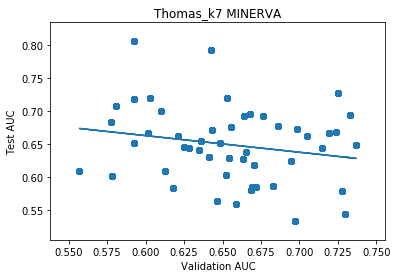

In [13]:
# check MINERVA PCs
dataset_num = 0


train_auc = []
test_auc = []
pc_range = range(num_pcs)
for i in pc_range:
    if not PC:
        train_auc.extend(all_datasets_dict['dataset' + str(dataset_num)][valKey])
        test_auc.extend(all_datasets_dict['dataset' + str(dataset_num)][testKey])
    else:   
        train_auc.extend(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][valKey])
        test_auc.extend(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][testKey])
    
x = np.array(train_auc)
y = np.array(test_auc)
plt.scatter( x,  y)

m, b = np.polyfit(x, y, 1)

plt.plot(x, m*x + b)

plt.xlabel("Validation AUC")
plt.ylabel("Test AUC")
plt.title(study_names[dataset_num] +" MINERVA")
plt.show()

In [14]:
#check overall correlation or trend
#total_pcs=5
auc_collection = dict()
pc_number_collection = dict()


for dataset_num in range(len(study_names)):
    print(dataset_num)
    auc_val = []
    pc_num = []
    auc = []
    plot_train = False
    plot_validation = True
    
    if plot_validation:
        extractKey = valKey
    else:
        extractKey = trainKey
    
    if not PC:
        auc_val.append(np.mean(all_datasets_dict['dataset' + str(dataset_num)][valKey]))
    else:

        if plot_train:
            ylab_input = "Train AUC with PCs"
        else:
            if plot_validation:
                ylab_input = "Validation AUC with PCs"
            else:
                ylab_input = "Test AUC with PCs"
        for i in pc_range:
            pc_num.append(i)
            auc_val.append(np.mean(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][valKey]))
            if plot_train:
                auc.append(np.mean(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][trainKey]))
            else:
                if plot_validation:
                    auc.append(np.mean(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][valKey]))
                else:
                    auc.append(np.mean(all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][testKey]))

            #export PC result for plotting
            output_dict = dict()
            if not pred:
                methodkey = "MINERVA_grid_PC" + str(i) + "_trans_clr_scale"
                output_dict[ methodkey]=dict()
                output_dict[ methodkey]['Random Forest'] = dict()
                output_dict[ methodkey]['Random Forest']['auc_all'] = all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][extractKey]
                pickle.dump(output_dict , open( data_folders[dataset_num] +  data_type + "_" + prefix_name + "_" + column_of_interest + "_" + "MINERVA_grid_PC" + str(i) + "_trans_clr_scale" + "_classification_auc.pkl", "wb" ) )


            else:
                output_dict['pearson'] = all_datasets_dict['dataset' + str(dataset_num)]["PC" + str(i)][extractKey]
                pickle.dump(output_dict , open( data_folders[dataset_num] +  data_type + "_" + prefix_name + "_" + column_of_interest + "_" + "MINERVA_grid_PC" + str(i) + "_trans_clr_scale" + "_pearson_and_mse.pkl", "wb" ) )


        
        x = np.array(pc_num)
        y = np.array(auc)
        plt.scatter( x,  y)

        m, b = np.polyfit(x, y, 1)

        plt.plot(x, m*x + b)

        plt.xlabel("# PC")
        plt.ylabel(ylab_input)
        plt.title(study_names[dataset_num] + " MINERVA")
        plt.show()
        #auc_collection.append(auc)
    
    
    auc_collection["dataset" + str(dataset_num)] = auc_val
    if PC:
        pc_number_collection["dataset" + str(dataset_num)] = pc_num
    

# plt.plot(x1, y1, "g")



# plt.plot(x2, y2, "r")

0


In [15]:
all_datasets_dict['dataset' + str(dataset_num)].keys()


dict_keys(['train_best_params', 'train_auc_trained', 'mean_train_cv_auc', 'mean_test_cv_auc', 'test_auc_trained', 'val_auc_trained', 'number samples'])

In [16]:
if PC:
    
    best_pc_per_dataset = []
    best_auc_per_dataset = []

    for dataset_num in range(len(study_names)):


        index_best_pc = auc_collection["dataset" + str(dataset_num)].index(max(auc_collection["dataset" + str(dataset_num)]))
        print(dataset_num)
        print(index_best_pc)
        best_auc_per_dataset.append(auc_collection["dataset" + str(dataset_num)][index_best_pc])
        best_pc_per_dataset.append(index_best_pc)
else:
    best_auc_per_dataset = []
    for dataset_num in range(len(study_names)):
        best_auc_per_dataset.append(auc_collection["dataset" + str(dataset_num)])

In [17]:
best_auc_per_dataset

[[0.6548963369550266]]

In [18]:
auc_collection["dataset" + str(dataset_num)]

[0.6548963369550266]

In [19]:
if PC:
    best_kmer = best_auc_per_dataset.index(max(best_auc_per_dataset))
    best_pc = best_pc_per_dataset[best_kmer]
else:
    best_kmer = best_auc_per_dataset.index(max(best_auc_per_dataset))



In [20]:
#best_pc =100

In [21]:
output_dict = dict()
pc0_dict = dict()


print("best_kmer" + str(study_names[best_kmer]))
if pred:
    #pc0_dict[method]=dict()
    if PC:
        all_datasets_dict['dataset' + str(best_kmer)]["PC" + str(best_pc)][testKey]
        output_dict['pearson'] = all_datasets_dict['dataset' + str(best_kmer)]["PC" + str(best_pc)][testKey]
        pc0_dict['pearson'] = all_datasets_dict['dataset' + str(best_kmer)]["PC0"][testKey]
        pickle.dump(pc0_dict , open( data_folders[best_kmer] +  data_type + "_" + prefix_name + "_" + column_of_interest + "_MINERVA0_grid_trans_clr_scale" + "_pearson_and_mse.pkl", "wb" ) )
       
    
        
    else:
        output_dict['pearson'] = all_datasets_dict['dataset' + str(best_kmer)][testKey]
    
    
    pickle.dump(output_dict , open( data_folders[best_kmer] +  data_type + "_" + prefix_name + "_" + column_of_interest + "_" + method + "_pearson_and_mse.pkl", "wb" ) )
       
else:
    output_dict[method]=dict()
    output_dict[method]['Random Forest'] = dict()
    
    pc0_dict['MINERVA0_grid_trans_clr_scale']=dict()
    pc0_dict['MINERVA0_grid_trans_clr_scale']['Random Forest'] = dict()
    
    if PC:
        all_datasets_dict['dataset' + str(best_kmer)]["PC" + str(best_pc)][testKey]
        output_dict[method]['Random Forest']['auc_all'] = all_datasets_dict['dataset' + str(best_kmer)]["PC" + str(best_pc)][testKey]
        #pc0_dict['MINERVA0_grid_trans_clr_scale']['Random Forest']['auc_all'] = all_datasets_dict['dataset' + str(best_kmer)]["PC0"][testKey]
        #pickle.dump(pc0_dict , open( data_folders[best_kmer] +  data_type + "_" + prefix_name + "_" + column_of_interest + "_MINERVA0_grid_trans_clr_scale" + "_classification_auc.pkl", "wb" ) )
       
    
        
    else:
        output_dict[method]['Random Forest']['auc_all'] = all_datasets_dict['dataset' + str(best_kmer)][testKey]
        
    
    pickle.dump(output_dict , open( data_folders[best_kmer] +  data_type + "_" + prefix_name + "_" + column_of_interest + "_" + method + "_classification_auc.pkl", "wb" ) )
    
    
    
    

best_kmerThomas_k7


In [22]:
data_folders[best_kmer] +  data_type + "_" + prefix_name + "_" + column_of_interest + "_" + method + "_classification_auc.pkl"

'/Users/leahbriscoe/Documents/MicroBatch/microbatch_vc/data/Thomas_k7/kmer_BatchCorrected_bin_crc_normal_dataaug_grid_trans_none_classification_auc.pkl'

In [23]:
output_dict

{'dataaug_grid_trans_none': {'Random Forest': {'auc_all': [0.6938296445338699,
    0.630449362843729,
    0.6997767857142858,
    0.6625,
    0.5872767857142858,
    0.7074670243684328,
    0.6445338698859825,
    0.6919642857142857,
    0.559375,
    0.6627232142857142,
    0.5859602056785156,
    0.6460988151128996,
    0.7924107142857142,
    0.5838169642857143,
    0.6440848214285715,
    0.6919293539011848,
    0.7196512407780014,
    0.6191964285714284,
    0.609375,
    0.6272321428571428,
    0.676056338028169,
    0.5642745361055219,
    0.61015625,
    0.7183035714285715,
    0.6551339285714286,
    0.6490051419628884,
    0.6684551754974289,
    0.6676339285714286,
    0.7198660714285714,
    0.6290178571428571,
    0.6780684104627768,
    0.602280348759222,
    0.6950892857142857,
    0.5790178571428571,
    0.6720982142857141,
    0.6838810641627543,
    0.6040688575899843,
    0.6676339285714286,
    0.6513392857142857,
    0.6410714285714285,
    0.6250838363514419,
    